In [1]:
#IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from utils_preprocess_couette import make_dataframe

%matplotlib inline 

#GET DATA

numpy_seed = 999
np.random.seed(numpy_seed)

'''Prepare Couette flow data'''
#Retau_train = [5200] #Use this to train only with one case
Retau_train1 = [93]
Retau_train2 = [500]

df_train1 = pd.concat([make_dataframe(Retau, nondim = 'k-eps') for Retau in Retau_train1])
df_train2 = pd.concat([make_dataframe(Retau, nondim = 'k-eps') for Retau in Retau_train2])
df_train1['a'] = df_train1[['a_uv', 'a_uu', 'a_vv', 'a_ww']].values.tolist()
df_train2['a'] = df_train2[['a_uv', 'a_uu', 'a_vv', 'a_ww']].values.tolist()

Retau_test = [220]
df_test = pd.concat([make_dataframe(Retau, nondim = 'k-eps') for Retau in Retau_test])
df_test['a'] = df_test[['a_uv', 'a_uu', 'a_vv', 'a_ww']].values.tolist()

# scale up target variable in order for stable training, will consider implementing automatic scaler 
df_train1['a_uv'] *= 1e1
df_train2['a_uv'] *= 1e1     
df_test['a_uv'] *= 1e1 
df_train1['Re_tau'] *= 1e-8 
df_train2['Re_tau'] *= 1e-8     
df_test['Re_tau'] *= 1e-8 
#Get validation data but can ignore it in this case
df_val=df_test


target_label = ['a_uv'] # or ['a'] (output_len = 1 if 'a_uv'; output_len = 4 if 'a')

In [3]:
#CONVERT DATA TO THE RIGHT TYPE

import torch
from torch import nn

In [4]:
#Format training1 x
xtrain1=df_train1['du_dy'].values
xtrain_torch1=torch.from_numpy(xtrain1)
xtrain_in1=xtrain_torch1.view(1,1,len(df_train1)).float()
#Add Reynolds number
re_train1=df_train1['Re_tau'].values
re_train1=torch.from_numpy(re_train1)
re_train1=re_train1.view(1,1,len(re_train1)).float()
xtrain_in1=torch.cat((xtrain_in1,re_train1),dim=1)

#Format training1 y+ (for boundary condition enforcement)
yplus_train1=df_train1['y+'].values
yplus_train_torch1=torch.from_numpy(yplus_train1)
yplus_train_in1=yplus_train_torch1.view(1,1,len(df_train1)).float()

#Format training1 y
ytrain1=df_train1['a_uv'].values
ytrain_torch1=torch.from_numpy(ytrain1)
ytrain_in1=ytrain_torch1.view(1,1,len(df_train1)).float()

#Format training2 x
xtrain2=df_train2['du_dy'].values
xtrain_torch2=torch.from_numpy(xtrain2)
xtrain_in2=xtrain_torch2.view(1,1,len(df_train2)).float()
#Add Reynolds number
re_train2=df_train2['Re_tau'].values
re_train2=torch.from_numpy(re_train2)
re_train2=re_train2.view(1,1,len(re_train2)).float()
xtrain_in2=torch.cat((xtrain_in2,re_train2),dim=1)

#Format training2 y+ (for boundary condition enforcement)
yplus_train2=df_train2['y+'].values
yplus_train_torch2=torch.from_numpy(yplus_train2)
yplus_train_in2=yplus_train_torch2.view(1,1,len(df_train2)).float()

#Format training2 y
ytrain2=df_train2['a_uv'].values
ytrain_torch2=torch.from_numpy(ytrain2)
ytrain_in2=ytrain_torch2.view(1,1,len(df_train2)).float()


In [5]:
#Format validation x
xval=df_val['du_dy'].values
xval_torch=torch.from_numpy(xval)
xval_in=xval_torch.view(1,1,len(df_val)).float()
#Add Reynolds number
re_trainval=df_val['Re_tau'].values
re_trainval=torch.from_numpy(re_trainval)
re_trainval=re_trainval.view(1,1,len(re_trainval)).float()
xval_in=torch.cat((xval_in,re_trainval),dim=1)

#Format validation y+ (for boundary condition enforcement)
yplus_val=df_val['y+'].values
yplus_val_torch=torch.from_numpy(yplus_val)
yplus_val_in=yplus_val_torch.view(1,1,len(df_val)).float()

#Format validation y
yval=df_val['a_uv'].values
yval_torch=torch.from_numpy(yval)
yval_in=yval_torch.view(1,1,len(df_val)).float()

#Format testing x
xtest=df_test['du_dy'].values
xtest_torch=torch.from_numpy(xtest)
xtest_in=xtest_torch.view(1,1,len(df_test)).float()
#Add Reynolds number
re_traintest=df_test['Re_tau'].values
re_traintest=torch.from_numpy(re_traintest)
re_traintest=re_traintest.view(1,1,len(re_traintest)).float()
xtest_in=torch.cat((xtest_in,re_traintest),dim=1)

#Format testing y+ (for boundary condition enforcement)
yplus_test=df_test['y+'].values
yplus_test_torch=torch.from_numpy(yplus_test)
yplus_test_in=yplus_test_torch.view(1,1,len(df_test)).float()

#Format testing y
ytest=df_test['a_uv'].values
ytest_torch=torch.from_numpy(ytest)
ytest_in=ytest_torch.view(1,1,len(df_test)).float()

In [6]:
maxlength=max(xtrain1.shape[0],xtrain2.shape[0],xval.shape[0],xtest.shape[0])

In [7]:
shapex1=xtrain1.shape[0]
shapex2=xtrain2.shape[0]

shapexval=xval.shape[0]
shapextest=xtest.shape[0]
zerostrain1=torch.zeros(1,1,maxlength-xtrain1.shape[0])
zerostrain2=torch.zeros(1,1,maxlength-xtrain2.shape[0])

zerosval=torch.zeros(1,1,maxlength-xval.shape[0])
zerostest=torch.zeros(1,1,maxlength-xtest.shape[0])

zerostrain1_double=torch.zeros(1,2,maxlength-xtrain1.shape[0])
zerostrain2_double=torch.zeros(1,2,maxlength-xtrain2.shape[0])

zerosval_double=torch.zeros(1,2,maxlength-xval.shape[0])
zerostest_double=torch.zeros(1,2,maxlength-xtest.shape[0])
# converting the data into GPU format
xtrain_in1=torch.cat((xtrain_in1,zerostrain1_double), 2)
yplus_train_in1=torch.cat((yplus_train_in1,zerostrain1), 2)
ytrain_in1=torch.cat((ytrain_in1,zerostrain1), 2)

xtrain_in2=torch.cat((xtrain_in2,zerostrain2_double), 2)
yplus_train_in2=torch.cat((yplus_train_in2,zerostrain2), 2)
ytrain_in2=torch.cat((ytrain_in2,zerostrain2), 2)

xval_in=torch.cat((xval_in,zerosval_double), 2)
yplus_val_in=torch.cat((yplus_val_in,zerosval), 2)
yval_in=torch.cat((yval_in,zerosval), 2)

xtest_in=torch.cat((xtest_in,zerostest_double), 2)
yplus_test_in=torch.cat((yplus_test_in,zerostest), 2)
ytest_in=torch.cat((ytest_in,zerostest), 2)

In [8]:
#CREATE THE MODEL INSIDE A CLASS
#import required for the activation functions
import torch.nn.functional as F

class CONV_NN_BC(nn.Module):
    def __init__(self, structure=None):
        super(CONV_NN_BC, self).__init__()
        
        self.fc0=nn.Sequential(
                nn.Conv1d(2, 5, 3, 1),
                nn.BatchNorm1d(5),
                nn.ELU(inplace=True))
        self.fc1=nn.Sequential(
                nn.Conv1d(5, 5, 11, 1),
                nn.BatchNorm1d(5),
                nn.ELU(inplace=True))
        self.fc2=nn.Sequential(
                nn.Conv1d(5, 10, 31, 1),
                nn.BatchNorm1d(10),
                nn.ELU(inplace=True))
        self.fc3=nn.Sequential(
                nn.Conv1d(10, 10, 41, 1),
                nn.BatchNorm1d(10),
                nn.ELU(inplace=True))
        self.fc4=nn.Sequential(
                nn.Conv1d(10, 10, 41, 1),

                nn.ELU(inplace=True))
        
        
        self.final = nn.Conv1d(1,1, 10, stride=10)
        self.f = nn.Flatten()
        self.zerotensor0=torch.zeros(1,2,1)
        self.zerotensor1=torch.zeros(1,5,5)
        self.zerotensor2=torch.zeros(1,5,15)
        self.zerotensor3=torch.zeros(1,10,20)
        self.zerotensor4=torch.zeros(1,10,20)
        self.beta=0.1

        
    def forward(self,x,yplus):
        x = torch.cat((x,self.zerotensor0), 2)
        x = torch.cat((self.zerotensor0,x), 2)
        x = self.fc0(x)
        #x = torch.cat((x,re),1)
        #pad tensor
        x = torch.cat((x,self.zerotensor1), 2)
        x = torch.cat((self.zerotensor1,x), 2)
        #Convolution
        x = self.fc1(x)
        #pad tensor
        x = torch.cat((x,self.zerotensor2), 2)
        x = torch.cat((self.zerotensor2,x), 2)
        #Convolution
        x = self.fc2(x)
        #pad tensor
        x = torch.cat((x,self.zerotensor3), 2)
        x = torch.cat((self.zerotensor3,x), 2)
        #Convolution
        x = self.fc3(x)
        #pad tensor
        x = torch.cat((x,self.zerotensor4), 2)
        x = torch.cat((self.zerotensor4,x), 2)
        #Convolution
        x = self.fc4(x)
        #Final layer 
        x = torch.mean(x,dim=0) #reshape tensor to apply transpose
        x = torch.transpose(x, 0, 1) #transpose tensor
        x = x[None,:,:] #reshape tensor
        x = self.f(x) #Flatten
        x = x[None,:,:] #reshape tensor
        x = self.final(x) #weighted average (set initial weights to 1 and divide by 8)
        #output = x
        output = (1. - torch.exp(-self.beta * yplus))*x #boundary condition enforcement
        return output

In [9]:
#CALL MODEL AND DEFINE LOSS AND OPTIMIZER FOR THE FUNCTION
# defining the model
model = CONV_NN_BC()

# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
# defining the loss function
criterion = nn.MSELoss()

# checking if GPU is available
#if torch.cuda.is_available():
    #model = model.cuda()
    #criterion = criterion.cuda()

In [10]:
nn.init.constant_(model.final.weight,-0.1)
nn.init.kaiming_uniform_(model.fc0[0].weight)
nn.init.kaiming_uniform_(model.fc1[0].weight)
nn.init.kaiming_uniform_(model.fc2[0].weight)
nn.init.kaiming_uniform_(model.fc3[0].weight)
nn.init.kaiming_uniform_(model.fc4[0].weight)

Parameter containing:
tensor([[[-0.0067,  0.0855, -0.1113,  ..., -0.0413, -0.0418, -0.0685],
         [ 0.0320,  0.0086,  0.0773,  ...,  0.0598, -0.0387,  0.0326],
         [-0.0955,  0.1208, -0.0458,  ..., -0.0516,  0.0164,  0.0129],
         ...,
         [ 0.0194,  0.0759,  0.1023,  ...,  0.0711, -0.0320, -0.0357],
         [ 0.0583,  0.0138, -0.0813,  ..., -0.0032, -0.1163, -0.1016],
         [-0.0706, -0.1018,  0.0940,  ..., -0.0604,  0.1079, -0.0604]],

        [[ 0.0039,  0.0664, -0.0072,  ...,  0.0979, -0.0007,  0.0739],
         [-0.0470, -0.0932, -0.0355,  ..., -0.0135, -0.0471,  0.0071],
         [ 0.0353, -0.0053,  0.0680,  ...,  0.0535,  0.1056, -0.0316],
         ...,
         [-0.0860,  0.0768,  0.0546,  ...,  0.0857,  0.0625, -0.0058],
         [-0.0436, -0.0769,  0.0279,  ...,  0.0510,  0.0804,  0.0280],
         [ 0.0044, -0.0630, -0.0359,  ..., -0.0208, -0.0905,  0.0226]],

        [[-0.0238, -0.0343,  0.0406,  ..., -0.1208,  0.0064, -0.0380],
         [ 0.0739,  0.0

In [11]:
#PRINT MODEL
print(model)

CONV_NN_BC(
  (fc0): Sequential(
    (0): Conv1d(2, 5, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (fc1): Sequential(
    (0): Conv1d(5, 5, kernel_size=(11,), stride=(1,))
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (fc2): Sequential(
    (0): Conv1d(5, 10, kernel_size=(31,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (fc3): Sequential(
    (0): Conv1d(10, 10, kernel_size=(41,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (fc4): Sequential(
    (0): Conv1d(10, 10, kernel_size=(41,), stride=(1,))
    (1): ELU(alpha=1.0, inplace=True)
  )
  (final): Conv1d(1, 1, kernel_size=(10,), st

In [12]:
print('Number of model parameters:', sum([p.numel() for p in model.parameters()]))

Number of model parameters: 10166


In [13]:
#DEFINE MODEL TRAINING FUNCTION1


def train1(epoch,k):
    
    #def squared_error(x,y):
    #sum((y - x) * (y - x))

    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train, yplus_train = xtrain_in1, ytrain_in1, yplus_train_in1
    # getting the validation set
    x_val, y_val, yplus_val = xval_in, yval_in, yplus_val_in 
    # getting the testing set
    x_test, y_test, yplus_test = xtest_in, ytest_in, yplus_test_in
    
        

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train,yplus_train)
    output_val = model(x_val,yplus_val)
    output_test=model(x_test,yplus_test)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    loss_test = criterion(output_test, y_test)
    if k%20==0:
        train_losses.append(loss_train)
        val_losses.append(loss_val)
        test_losses.append(loss_test)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%50 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss train:', loss_train.item(), 'loss val:', loss_val.item(), 'loss test:', loss_test.item())
    

In [14]:
#DEFINE MODEL TRAINING FUNCTION2


def train2(epoch,k):
    
    #def squared_error(x,y):
    #sum((y - x) * (y - x))

    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train, yplus_train = xtrain_in2, ytrain_in2, yplus_train_in2
    # getting the validation set
    x_val, y_val, yplus_val = xval_in, yval_in, yplus_val_in 
    # getting the testing set
    x_test, y_test, yplus_test = xtest_in, ytest_in, yplus_test_in
    # converting the data into GPU format
    
        

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train,yplus_train)
    output_val = model(x_val,yplus_val)
    output_test=model(x_test,yplus_test)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    loss_test = criterion(output_test, y_test)
    if k%20==0:
        train_losses.append(loss_train)
        val_losses.append(loss_val)
        test_losses.append(loss_test)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%50 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss train:', loss_train.item(), 'loss val:', loss_val.item(), 'loss test:', loss_test.item())
    

In [15]:
import time
epoch=1
train_losses = []
val_losses = []
test_losses = []
count=0
k=0


for i in range(10000):
    k=k+1
    train1(epoch,k)
    k=k+1
    train2(epoch,k)
    count=count+1
    #torch.cuda.empty_cache()
    
    
    if count%100==0:
        print('Epoch : ',count, '\t', 'loss train:', train_losses[-1].item(), 'loss val:', val_losses[-1].item(), 'loss test:', test_losses[-1].item())

Epoch :  100 	 loss train: 0.012165060266852379 loss val: 0.014535414054989815 loss test: 0.014535414054989815


KeyboardInterrupt: 

In [10]:
xtrain_in1=xtrain_in1[:,:,0:shapex1]
xtrain_in2=xtrain_in2[:,:,0:shapex2]
yplus_train_in1=yplus_train_in1[:,:,0:shapex1]
yplus_train_in2=yplus_train_in2[:,:,0:shapex2]
ytrain_in1=ytrain_in1[:,:,0:shapex1]
ytrain_in2=ytrain_in2[:,:,0:shapex2]



xval_in=xval_in[:,:,0:shapexval]
yplus_val_in=yplus_val_in[:,:,0:shapexval]
yval_in=yval_in[:,:,0:shapexval]

xtest_in=xtest_in[:,:,0:shapextest]
yplus_test_in=yplus_test_in[:,:,0:shapextest]
ytest_in=ytest_in[:,:,0:shapextest]

a_train1=model(xtrain_in1,yplus_train_in1)
a_train2=model(xtrain_in2,yplus_train_in2)
a_train=torch.cat((a_train1,a_train2),2)
print(a_train.shape)
a_train=torch.mean(a_train, dim=0)
a_train=torch.mean(a_train, dim=0)
b_train=torch.cat((ytrain_in1,ytrain_in2),2)
b_train=torch.mean(b_train, dim=0)
b_train=torch.mean(b_train, dim=0)

a_val=model(xval_in,yplus_val_in)
a_val=torch.mean(a_val, dim=0)
a_val=torch.mean(a_val, dim=0)
b_val=torch.mean(yval_in, dim=1)
b_val=torch.mean(b_val, dim=0)
test_performance=criterion(ytest_in,model(xtest_in,yplus_test_in))
a_test=torch.mean(model(xtest_in,yplus_test_in), dim=0)
a_test=torch.mean(a_test, dim=0)
b_test=torch.mean(ytest_in, dim=1)
b_test=torch.mean(b_test, dim=0)
a_train=a_train.cpu().detach().numpy() 
b_train=b_train.cpu().detach().numpy()
a_val=a_val.cpu().detach().numpy() 
b_val=b_val.cpu().detach().numpy()
a_test=a_test.cpu().detach().numpy() 
b_test=b_test.cpu().detach().numpy()


from sklearn.metrics import r2_score
print('R^2: ','\t', 'train:', r2_score(b_train,a_train), 'val:', r2_score(b_val,a_val), 'test:', r2_score(b_test,a_test))



test_performance_piecewise=np.zeros_like(a_test)
for i in range(len(a_test)):
####################################################################################   
    test_performance_piecewise[i]=criterion(ytest_in[0,0,i],model(xtest_in,yplus_test_in)[0,0,i])
####################################################################################

torch.Size([1, 1, 192])
R^2:  	 train: 0.9999700690806259 val: 0.9575072451483224 test: 0.9575072451483224


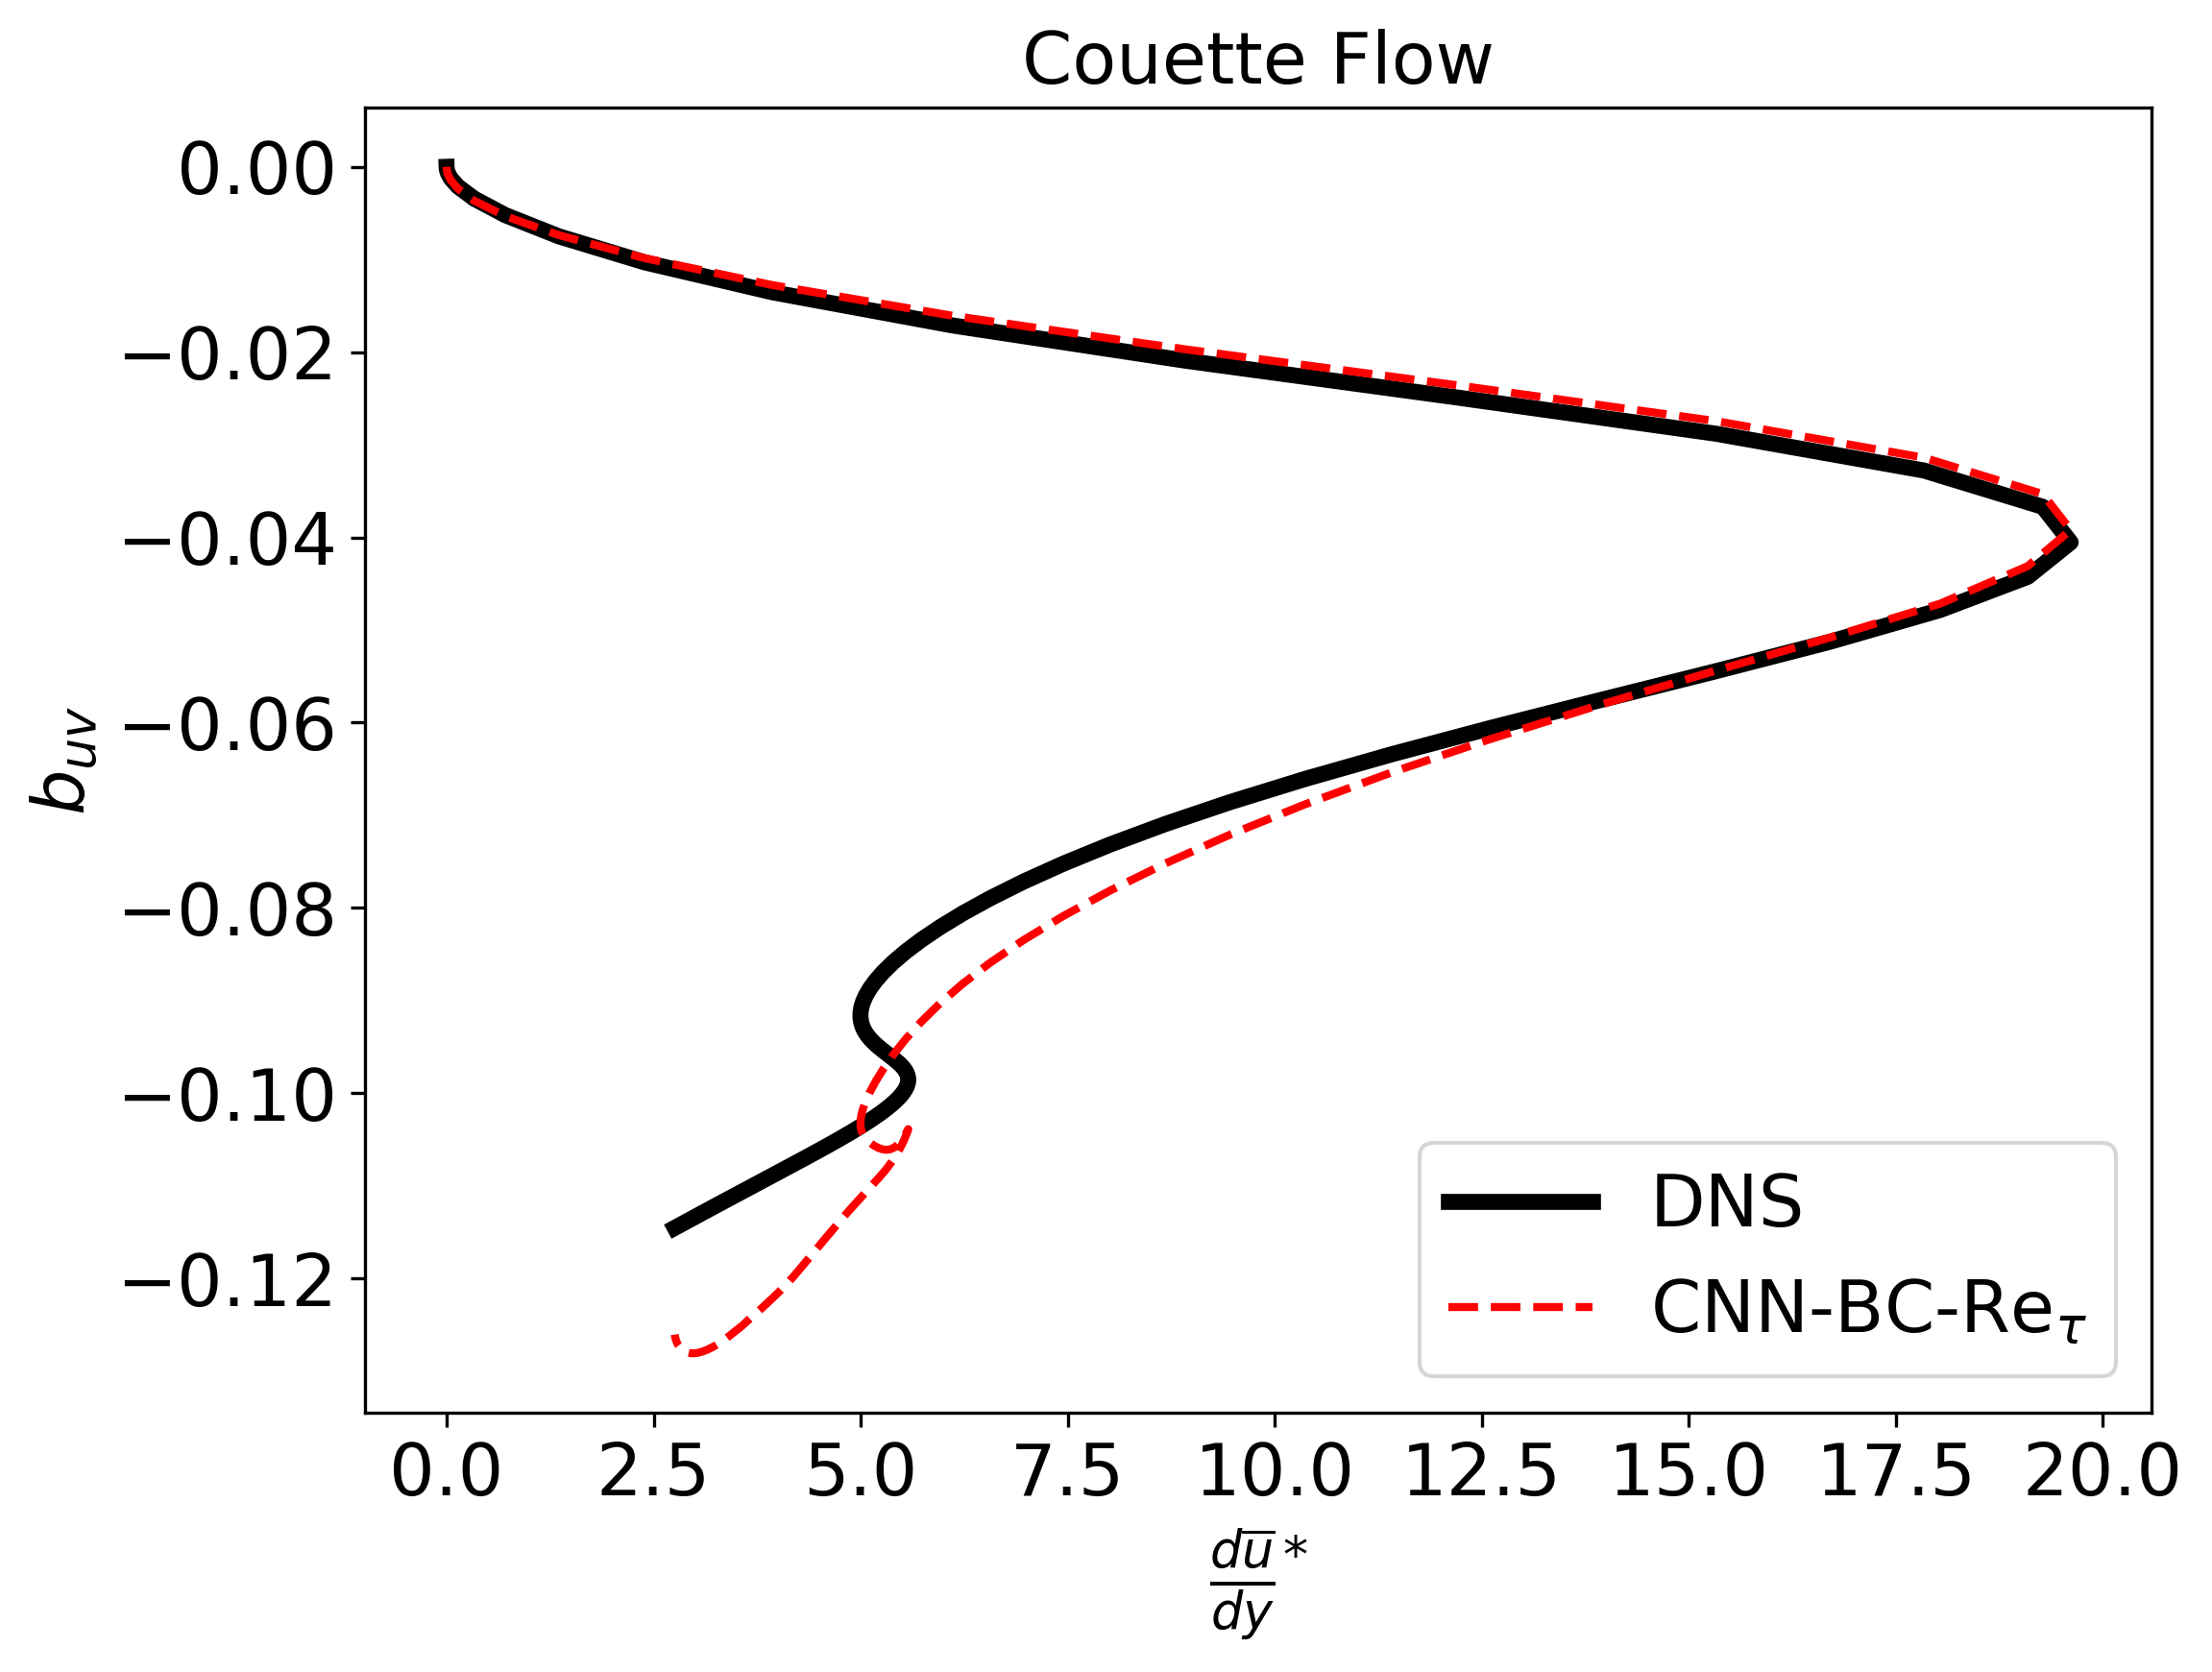

In [15]:
fig = plt.figure(figsize=[8,6], dpi=300)
plt.plot(xval_in[0,0,:].detach().cpu().numpy(),(yval_in[0,0,:]/10).detach().cpu().numpy(), 'k',linewidth=4, label='DNS')
plt.plot(xval_in[0,0,:].detach().cpu().numpy(), (model(xval_in,yplus_val_in)[0,0,:]/10).detach().cpu().numpy(),'r--',linewidth=2, label=r'CNN-BC-Re$_{\tau}$')

plt.legend(loc='lower right',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Couette Flow',fontsize=18)

plt.xlabel(r'$\frac{d\overline{u}}{dy}^{*}$', fontsize=18); plt.ylabel(r'$b_{uv}$', fontsize=18);
fig.savefig('couette_case1_1.png',bbox_inches = 'tight')

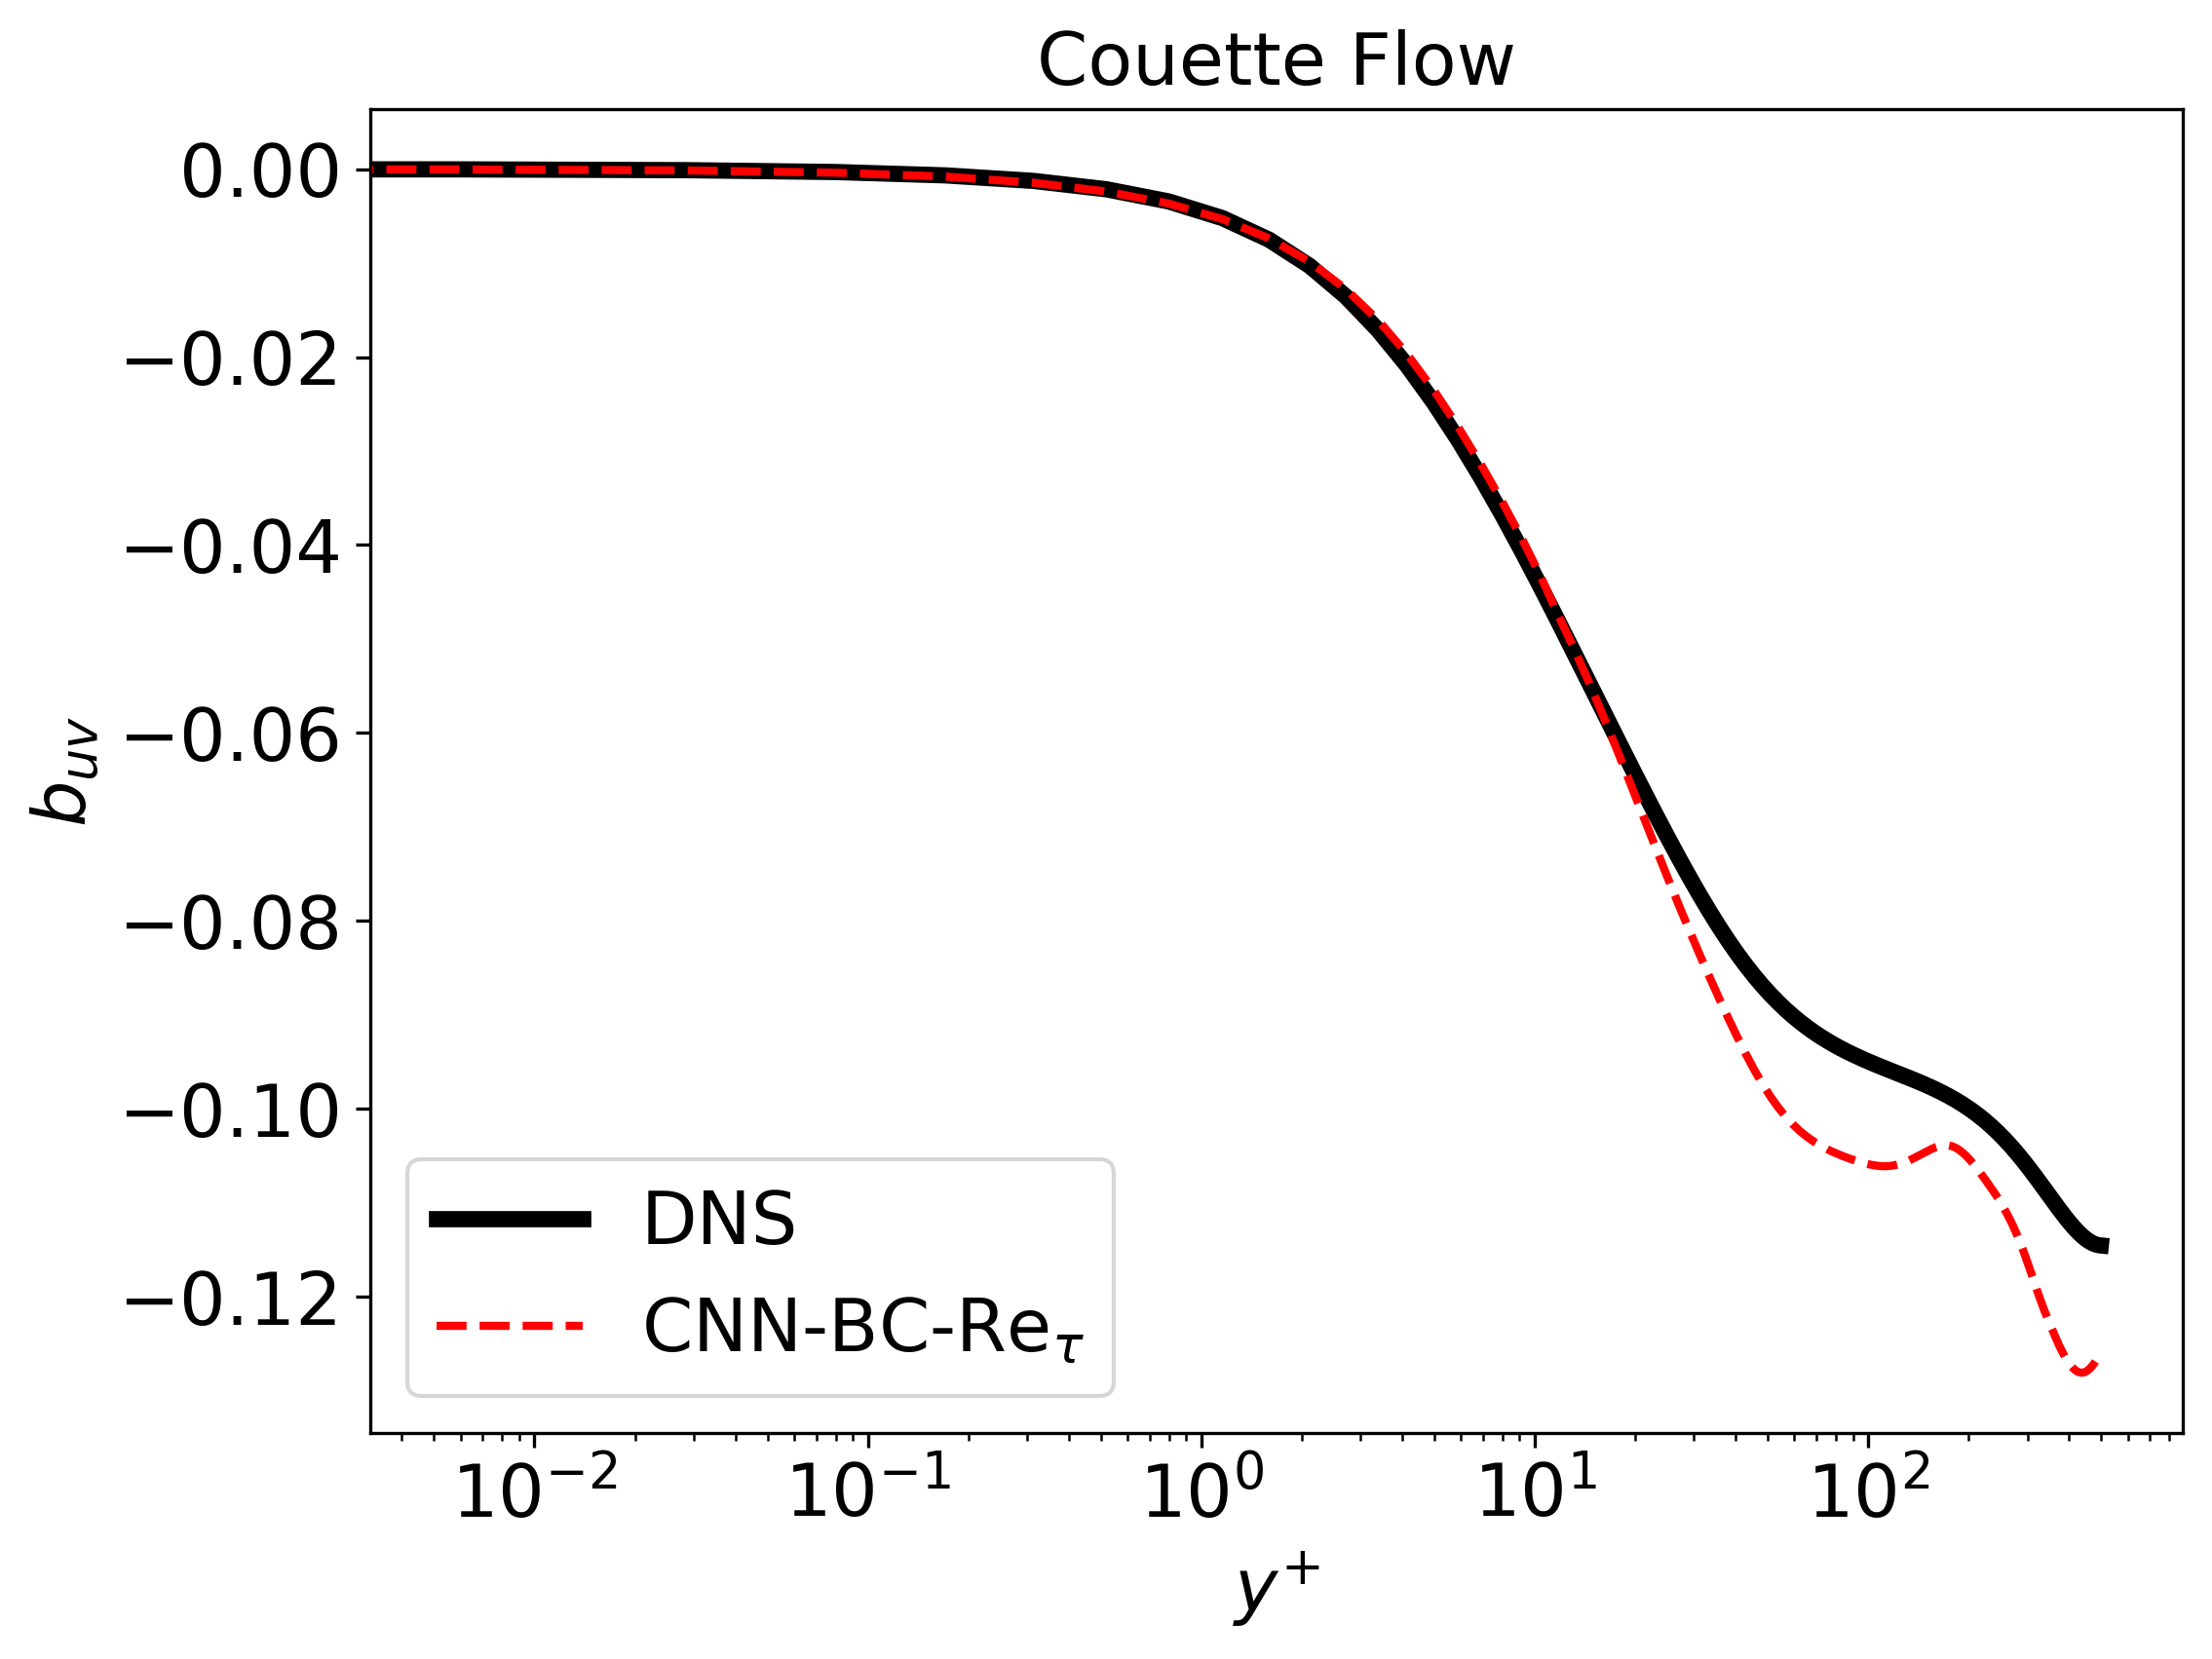

In [14]:
fig = plt.figure(figsize=[8,6], dpi=300)
plt.plot(yplus_val_in[0,0,:].detach().cpu().numpy(),(yval_in[0,0,:]/10).detach().cpu().numpy(), 'k',linewidth=4, label='DNS')
plt.plot(yplus_val_in[0,0,:].detach().cpu().numpy(), (model(xval_in,yplus_val_in)[0,0,:]/10).detach().cpu().numpy(),'r--',linewidth=2, label=r'CNN-BC-Re$_{\tau}$')


plt.legend(loc='lower left',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Couette Flow',fontsize=18)
plt.xscale("log"); 

plt.xlabel(r'$y^{+}$', fontsize=18); plt.ylabel(r'$b_{uv}$', fontsize=18);
fig.savefig('couette_case1_2.png',bbox_inches = 'tight')

<font size="45">Interpretability</font>

<h1>OCCLUSION

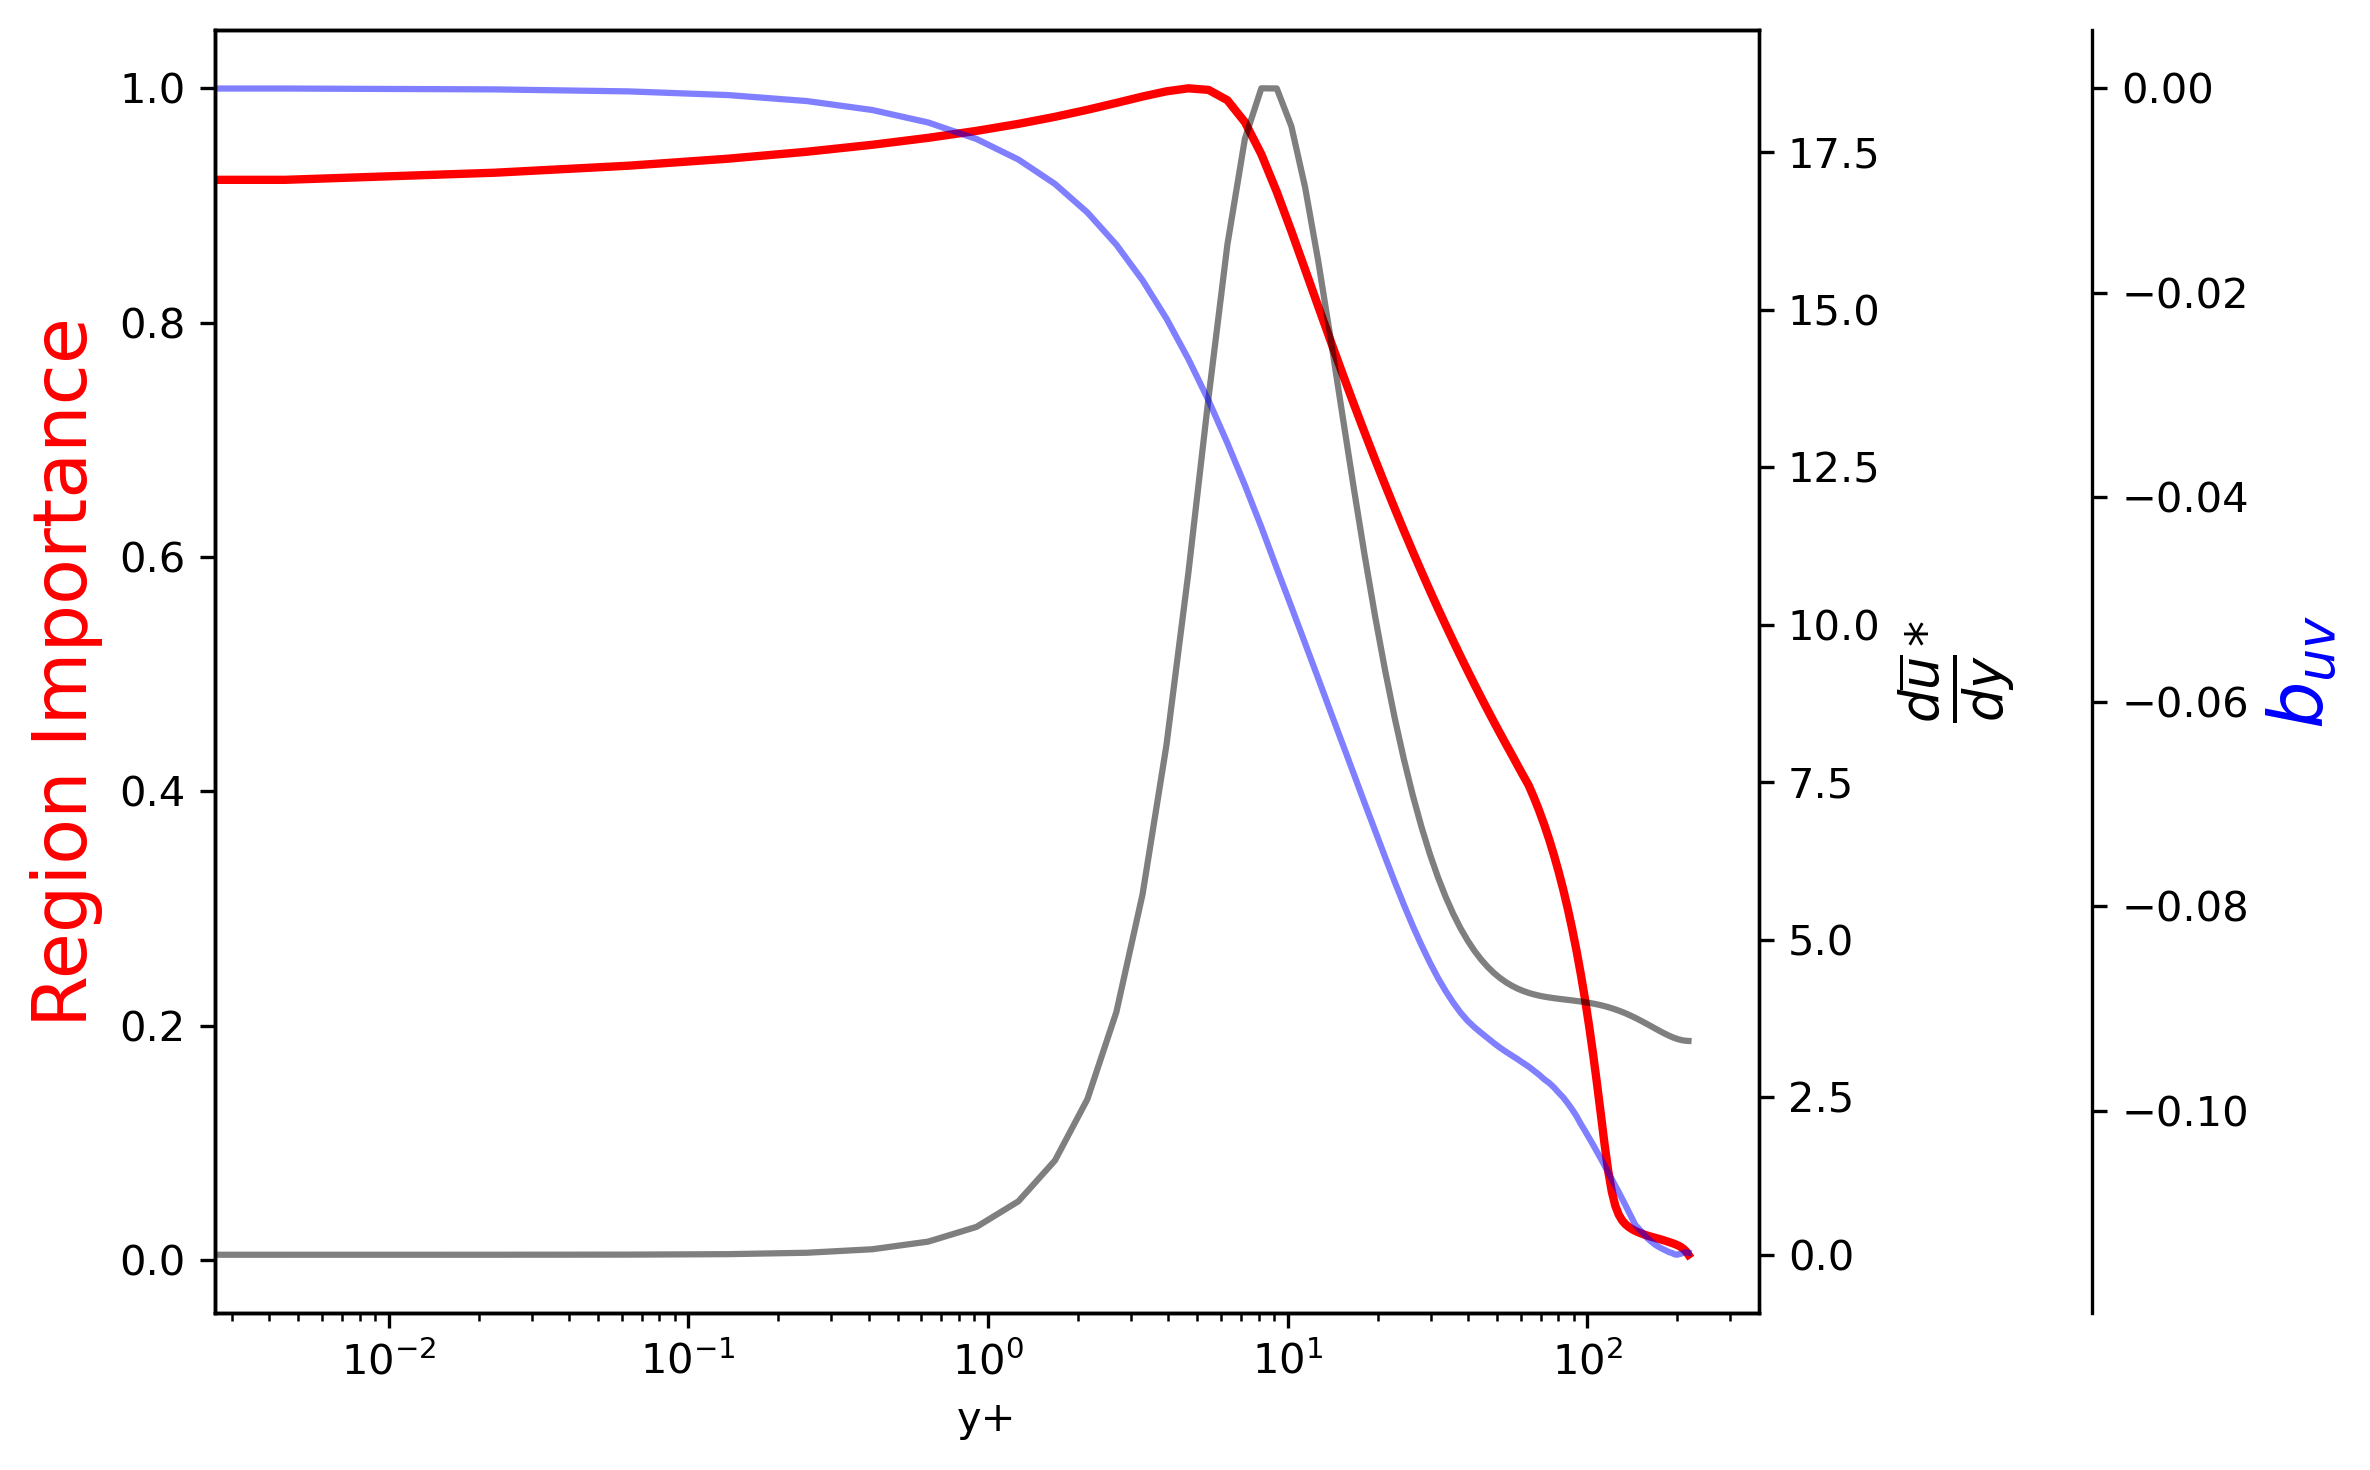

In [160]:
#OCCLUSION ALGORITMH

xtest_in=xtest_in[:,:,0:shapextest]
yplus_test_in=yplus_test_in[:,:,0:shapextest]
ytest_in=ytest_in[:,:,0:shapextest]

n_occlusions=50 #How many entries to occlude
importance=np.zeros(len(xtest_in[0,0])) #create perfomance array full of zeros
for i in range(len(xtest_in[0,0])-(n_occlusions-1)):
    xtest_in_trial=xtest_in.clone().detach().numpy() #If you try to copy the tensor directly it overwrites the original tensor
    
    for j in range(n_occlusions):
        xtest_in_trial[:,:,i+j]=0 #occlude entries
    
    xtest_in_trial_torch=torch.from_numpy(xtest_in_trial) #convert back to pytorch tensor
    
    trial=model(xtest_in_trial_torch,yplus_test_in) #Feed into the model
    a_test_trial=trial.clone().detach().numpy() #detach again
    b_test_trial=ytest_in.clone().detach().numpy() #detach agan
    a_test_trial=a_test_trial[0,0,:] #Reshape
    b_test_trial=b_test_trial[0,0,:] #Reshape
    
    for k in range(n_occlusions):
        importance[i+k]=importance[i+k]+abs(test_performance-criterion(ytest_in,trial)) #The higher the difference the more important the region is  

countdown=n_occlusions
for i in range(len(xtest_in[0,0])):
    if (i+1)<=n_occlusions:
        importance[i]=importance[i]/(i+1)
    elif (i+1)>(len(xtest_in[0,0])-(n_occlusions-1)):
        countdown=countdown-1
        importance[i]=importance[i]/(countdown)
    else:
        importance[i]=importance[i]/n_occlusions

importance=importance/max(importance) #normalize importance

# create figure and axis objects with subplots()
import matplotlib.pyplot as plt 

# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5), dpi=300) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlabel("y+")
host.set_ylabel("Region Importance", fontsize=18)
par1.set_ylabel(r'$\frac{d\overline{u}}{dy}^{*}$', fontsize=18)
par2.set_ylabel(r'$b_{uv}$', fontsize=18)

color1 = 'r'
color2 = 'k'
color3 = 'b'

p2, = par1.plot(df_test['y+'], df_test['du_dy'], label=r'$\frac{d\overline{u}}{dy}^{*}$')
p3, = par2.plot(df_test['y+'], a_test/10, label=r'$b_{uv}$')
p1, = host.plot(df_test['y+'], importance, label="Region Importance")



p1.set_color(color1)
p2.set_color(color2)
p3.set_color(color3)
p1.set_linewidth(2)
p2.set_alpha(0.5)
p3.set_alpha(0.5)

lns = [p1, p2, p3]
#host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 80))

# no x-ticks                 
par2.xaxis.set_ticks([])
plt.xscale("log"); 



host.yaxis.label.set_color(color1)
par1.yaxis.label.set_color(color2)
par2.yaxis.label.set_color(color3)

# Adjust spacings w.r.t. figsize
fig.tight_layout()


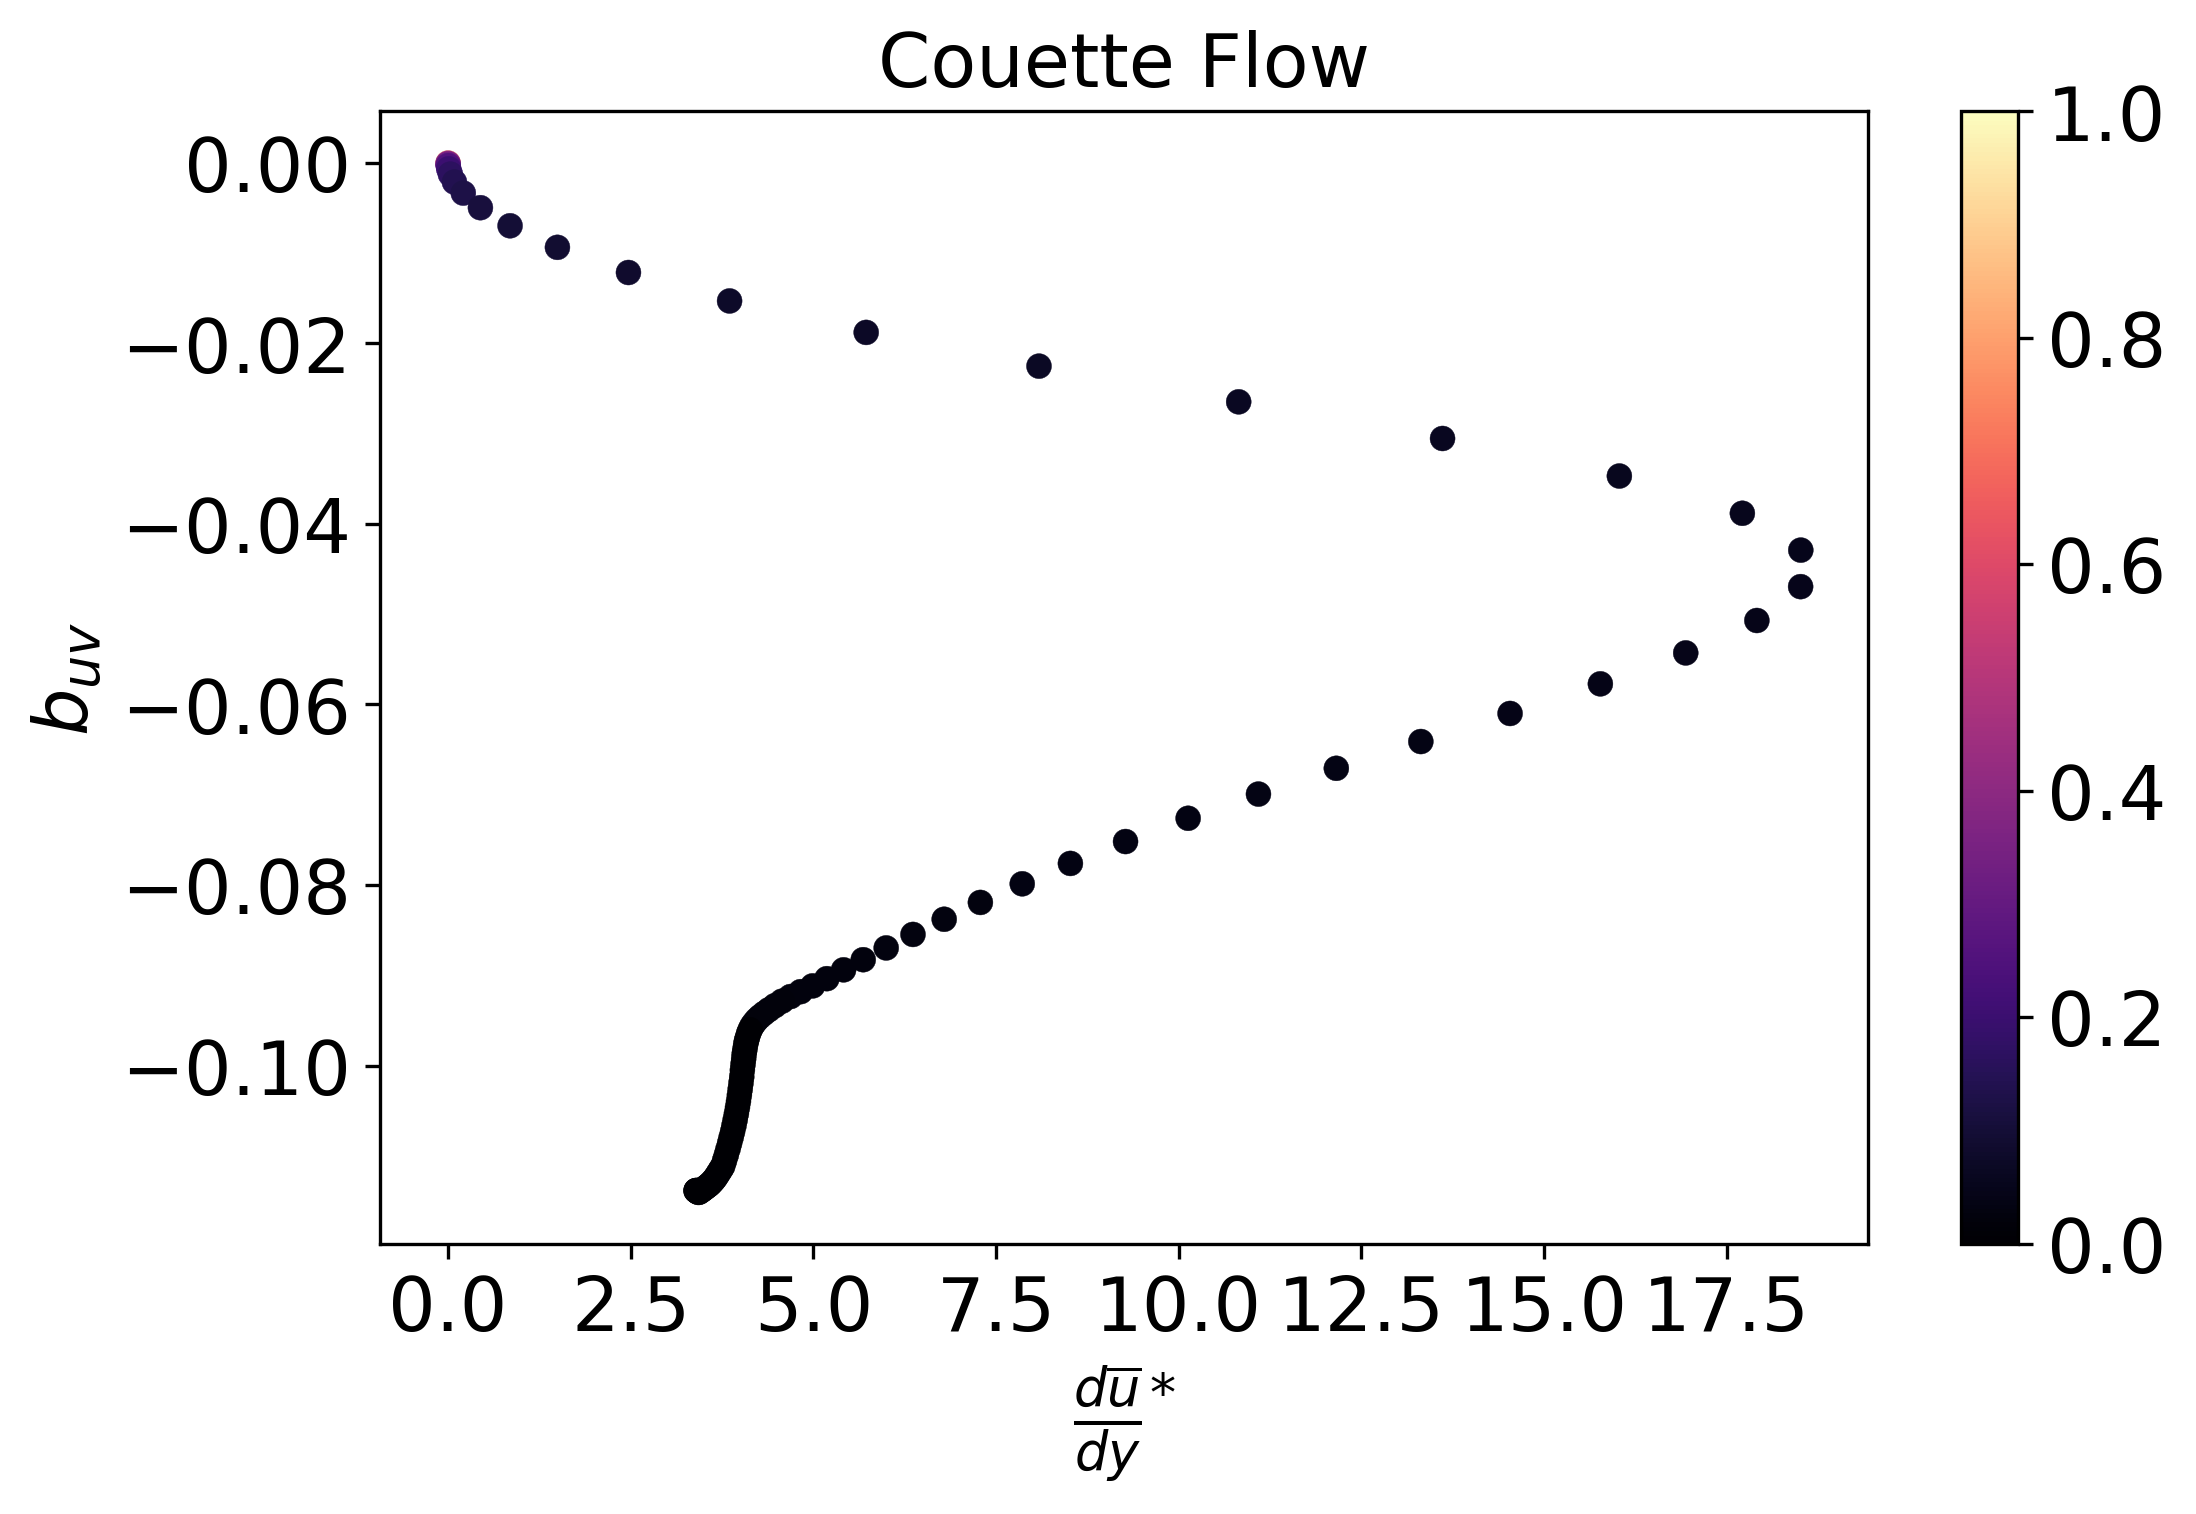

In [159]:
fig, host = plt.subplots(figsize=(8,5), dpi=300)
plt.scatter(df_test['du_dy'],a_test/10,c=importance, cmap="magma",linewidths=.1)
#plt.scatter(df_test['du_dy'],(yval_in[0,0,:]/10).detach().cpu().numpy(),linewidths=.1)
plt.xlabel(r'$\frac{d\overline{u}}{dy}^{*}$', fontsize=18); plt.ylabel(r'$b_{uv}$', fontsize=18);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Couette Flow', fontsize=18)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)
#fig.savefig('zz_1d.png',bbox_inches = 'tight')

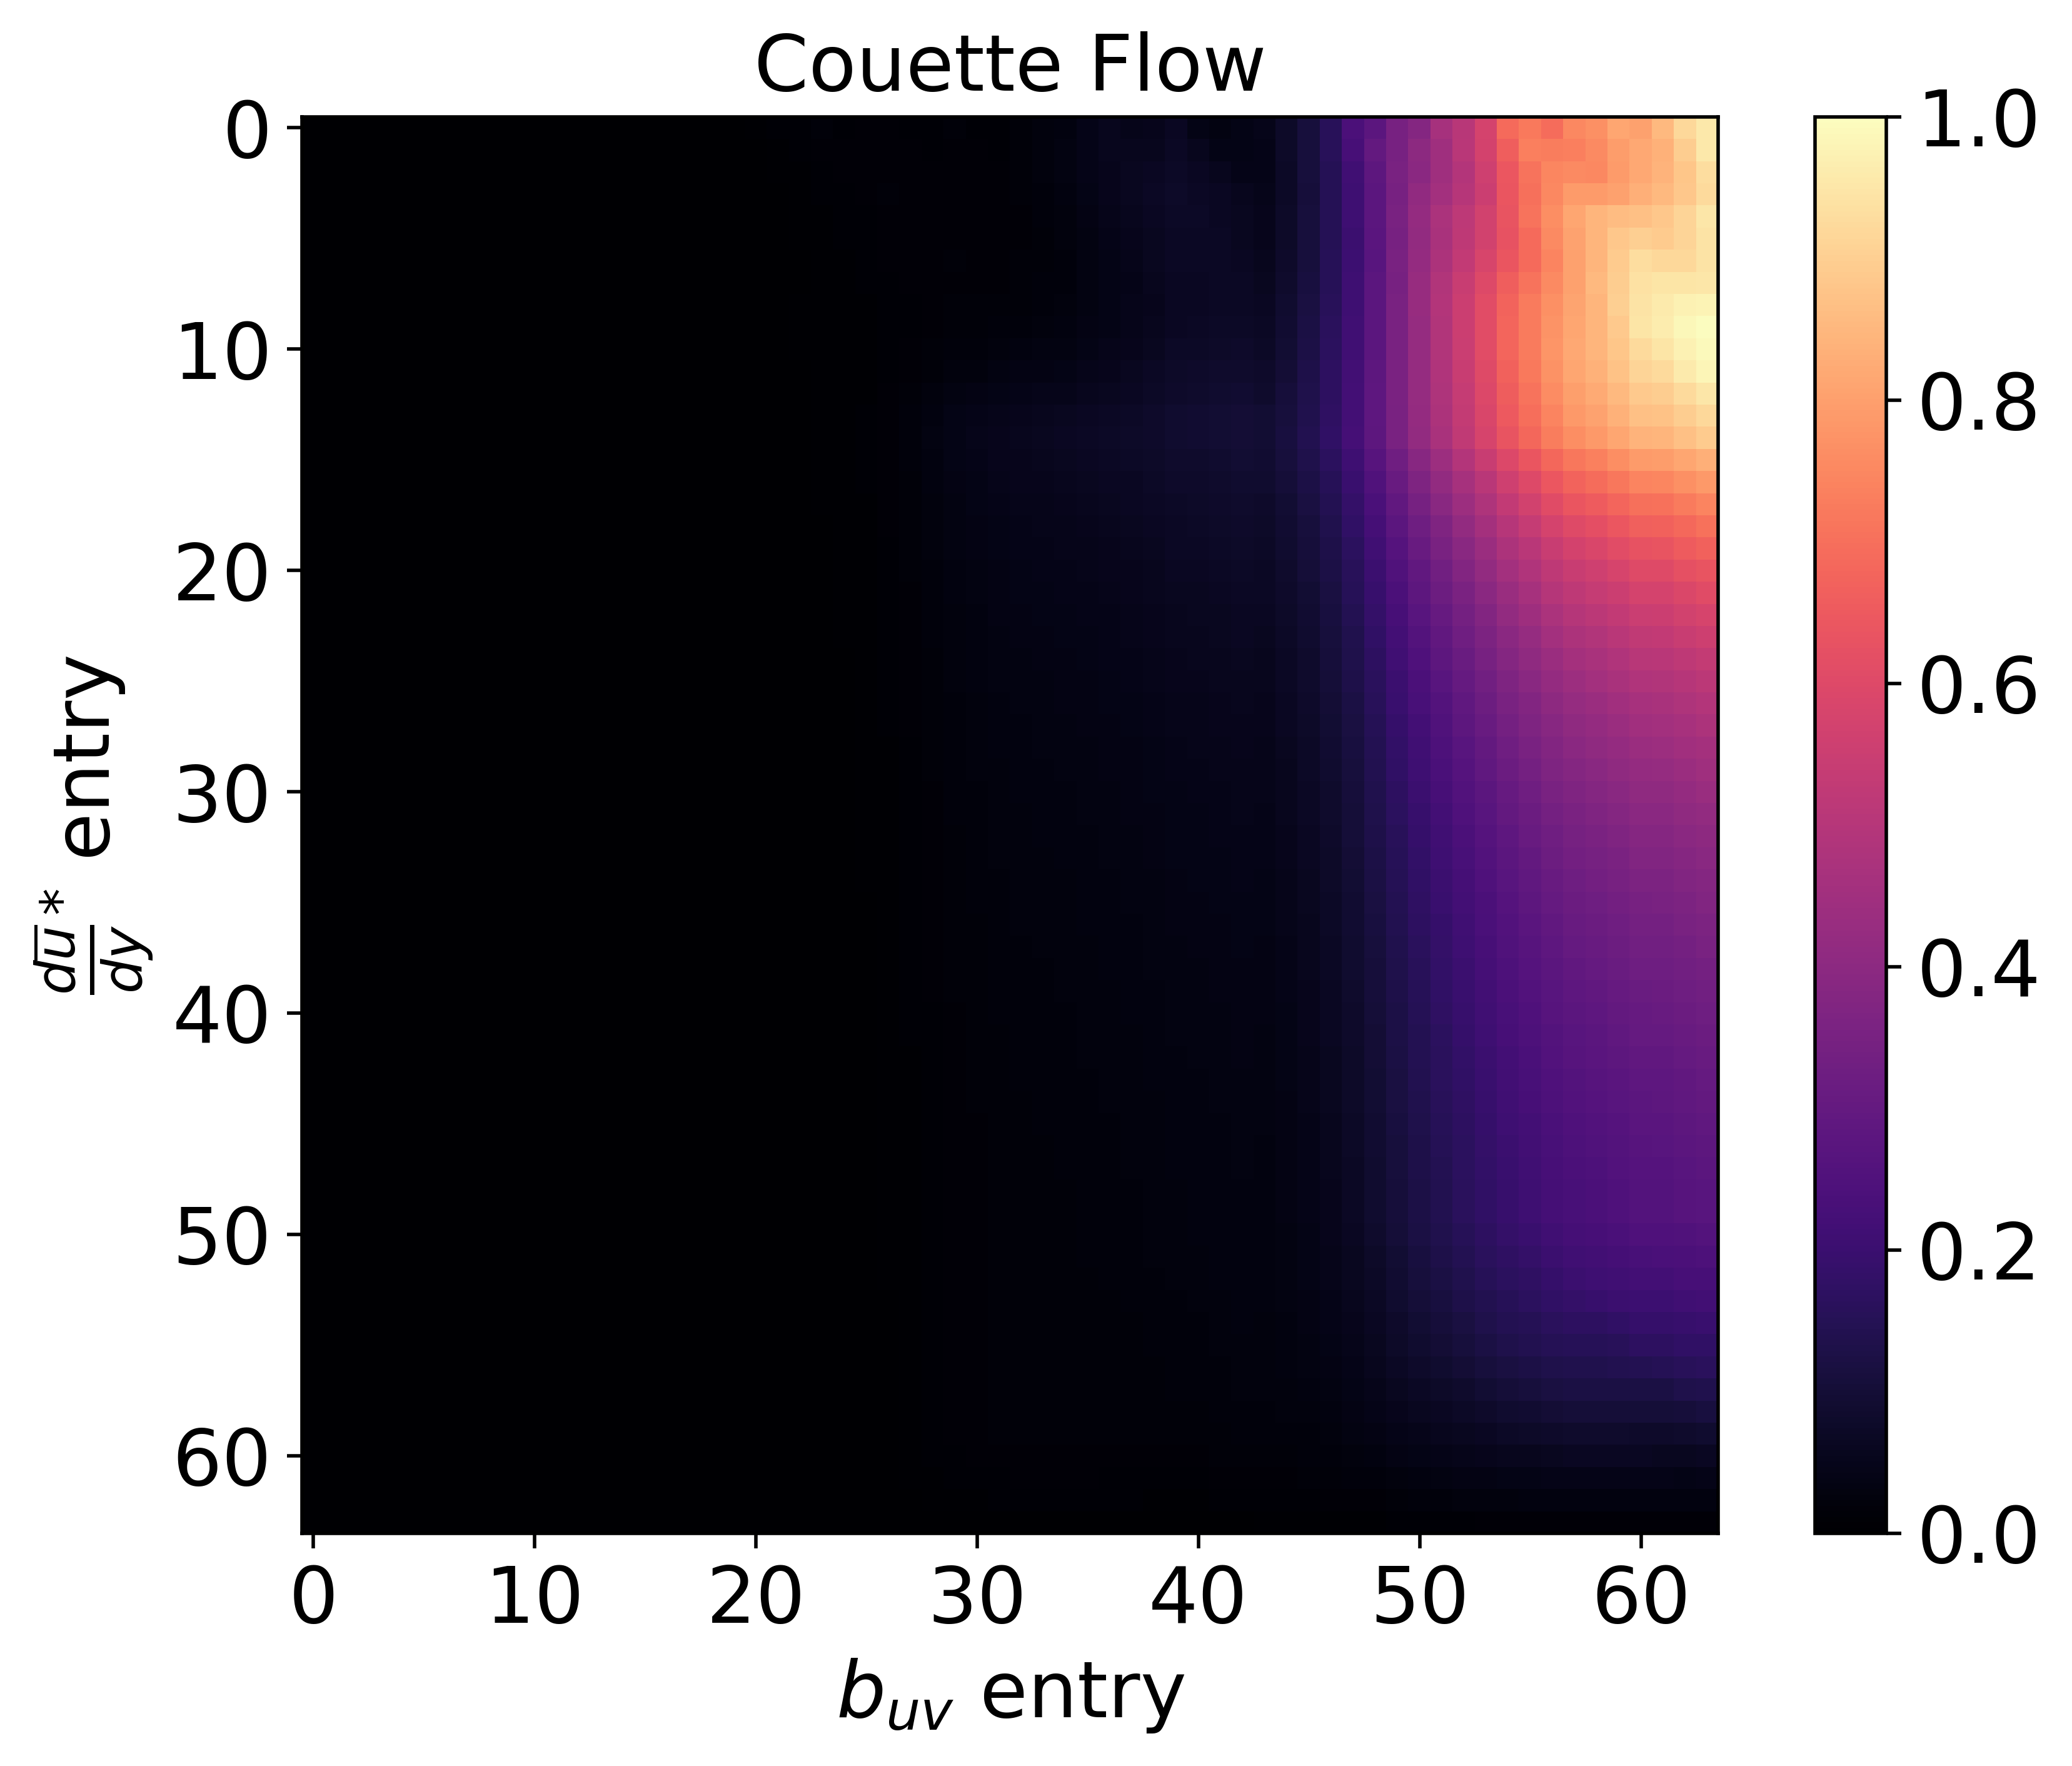

In [13]:
#OCCLUSION MAP ALGORITMH

#xtest_in=xtest_in[:,:,0:shapextest]
#yplus_test_in=yplus_test_in[:,:,0:shapextest]
#ytest_in=ytest_in[:,:,0:shapextest]

n_occlusions=50 #How many entries to occlude
importance_map=np.zeros((len(xtest_in[0,0]), len(xtest_in[0,0]))) #create perfomance array full of zeros
for i in range(len(xtest_in[0,0])-(n_occlusions-1)):
    xtest_in_trial=xtest_in.clone().detach().numpy() #If you try to copy the tensor directly it overwrites the original tensor
    
    for j in range(n_occlusions):
        xtest_in_trial[:,:,i+j]=0 #occlude entries
    
    xtest_in_trial_torch=torch.from_numpy(xtest_in_trial) #convert back to pytorch tensor
    
    trial=model(xtest_in_trial_torch,yplus_test_in) #Feed into the model
    a_test_trial=trial.clone().detach().numpy() #detach again
    b_test_trial=ytest_in.clone().detach().numpy() #detach agan
    a_test_trial=a_test_trial[0,0,:] #Reshape
    b_test_trial=b_test_trial[0,0,:] #Reshape
    
    for k in range(n_occlusions):
        for l in range(len(xtest_in[0,0])): #calculations for each entry
            #importance_map[i+k,l]=importance_map[i+k,l]+abs(test_performance_piecewise[l]-criterion(trial[0,0,l],ytest_in[0,0,l])).cpu().detach().numpy()
            importance_map[i+k,l]=importance_map[i+k,l]+abs(test_performance_piecewise[l]-(b_test_trial[l]-a_test_trial[l])**2)
            

countdown=n_occlusions
for i in range(len(xtest_in[0,0])):
    if (i+1)<n_occlusions:
        importance_map[i,:]=importance_map[i,:]/(i+1)
    elif (i+1)>(len(xtest_in[0,0])-(n_occlusions-1)):
        countdown=countdown-1
        importance_map[i,:]=importance_map[i,:]/(countdown)
    else:
        importance_map[i,:]=importance_map[i,:]/n_occlusions

importance_map=importance_map/importance_map.max() #normalize importance

fig = plt.figure(figsize=[8,6], dpi=500)
cmap = plt.cm.get_cmap("magma", 147456)
plt.ylabel(r'$\frac{d\overline{u}}{dy}^{*}$ entry', fontsize=18); plt.xlabel(r'$b_{uv}$ entry', fontsize=18);
plt.imshow(importance_map, cmap=cmap)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Couette Flow', fontsize=18)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)
fig.savefig('zz_couette_2d.png',bbox_inches = 'tight')
